# This is just a playground for me 

In [14]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, 0] 
        Y_locations = X[:, 1] 
        Z_locations = X[:, 2]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 1].assign(X[:,1] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 1].assign(X[:,1]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, 0].assign(X[:, 0]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, 0].assign(X[:, 0]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 2].assign(X[:, 2]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 2].assign(X[:, 2]-move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
    
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(**kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 42 # use 0 as default if the class is not there 
    Y_locations = [0] * 42 
    Z_locations = [0] * 42
    x = y = z = 0 
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y
                Z_locations[z] = landmark.z
                x += 1; y += 1; z += 1;
    X_locations = np.array(X_locations)
    Y_locations = np.array(Y_locations)
    Z_locations = np.array(Z_locations) 
    locations = np.array([X_locations[np.nonzero(X_locations)].mean(), Y_locations[np.nonzero(Y_locations)].mean(), Z_locations[np.nonzero(Z_locations)].mean()])
    hands.close()
    return np.nan_to_num(locations)


def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 3))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations) 

def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2820, in while_loop
    return result  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/control_flow_ops.py", line 2768, in <lambda>
    body = lambda i, lv: (i + 1, orig_body(*lv))  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/map_fn.py", line 499, in compute
    return (i + 1, tas)  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/ops/map_fn.py", line 497, in <listcomp>
    ta.write(i, value) for (ta, value) in zip(tas, result_value_batchable)  File "

In [2]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('mean_point_folds'): 
    with open(f"mean_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [9]:
from glob import glob
from tqdm import tqdm 
import tensorflow_addons as tfa
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()
    
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        M = np.random.permutation(X_train.shape[0])
        X_train, y_train = X_train[M], y_train[M]


        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        print(model.layers)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        # plot accuracy and loss 
        plot(history)

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"file is {file}, prediction is {predict_on_video(model, file)}")

In [37]:
def shuffle(X, y): 
    X = np.concatenate([X_i for X_i in X])
    y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(X.shape[0])
    X, y = X[N], y[N]
    return X, y
    
X, y = shuffle(X, y)

In [29]:
def make_simple_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.GaussianNoise(0.2),
        tf.keras.layers.LSTM(32, return_sequences=False), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(
Epoch 1/200
3/3 [==============================] - 1s 234ms/step - loss: 0.6998 - accuracy: 0.4000 - precision_29: 0.3704 - recall_29: 0.2439 - val_loss: 0.6944 - val_accuracy: 0.3500 - val_precision_29: 0.2500 - val_recall_29: 0.2222
Epoch 2/200
3/3 [==============================] - 0s 132ms/step - loss: 0.6955 - accuracy: 0.4375 - precision_29: 0.4444 - recall_29: 0.3902 - val_loss: 0.6946 - val_accuracy: 0.3500 - val_precision_29: 0.2500 - val_recall_29: 0.2222
Epoch 3/200
3/3 [==============================] - 0s 140ms/step - loss: 0.6964 - accuracy: 0.4625 - precision_29: 0.4722 - recall_29: 0.4146 - v

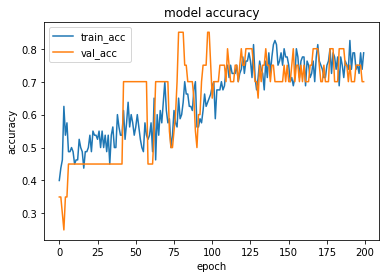

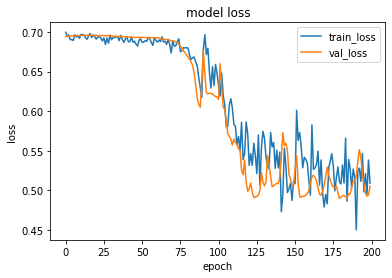

<ipython-input-14-054d4ff86c9b>:256: RuntimeWarning: Mean of empty slice.
  locations = np.array([X_locations[np.nonzero(X_locations)].mean(), Y_locations[np.nonzero(Y_locations)].mean(), Z_locations[np.nonzero(Z_locations)].mean()])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
1it [00:00, 14513.16it/s]
file is another_control.mov, prediction is [[0.32727057]]
1it [00:00, 13706.88it/s]
file is short_armflapping.mov, prediction is [[0.5849702]]
1it [00:00, 18893.26it/s]
file is control_far.mov, prediction is [[0.31122148]]
1it [00:00, 13315.25it/s]
file is long_armflapping.mov, prediction is [[0.40351966]]
1it [00:00, 12483.05it/s]
file is me_reading_control.mov, prediction is [[0.29878277]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.5925334]]
Epoch 1/200
3/3 [==============================] - 1s 312ms/

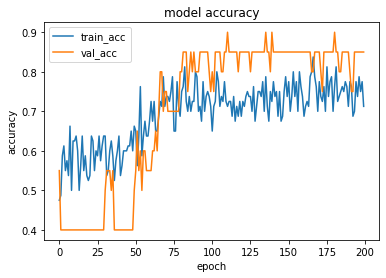

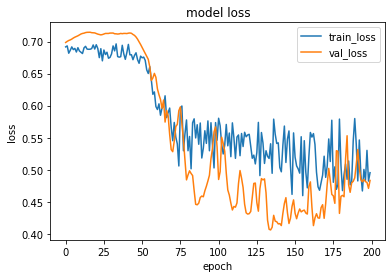

1it [00:00, 14266.34it/s]
file is another_control.mov, prediction is [[0.37381303]]
1it [00:00, 18893.26it/s]
file is short_armflapping.mov, prediction is [[0.6785617]]
1it [00:00, 13706.88it/s]
file is control_far.mov, prediction is [[0.34812418]]
1it [00:00, 15141.89it/s]
file is long_armflapping.mov, prediction is [[0.4924824]]
1it [00:00, 16131.94it/s]
file is me_reading_control.mov, prediction is [[0.3443117]]
1it [00:00, 14463.12it/s]
file is me_armflapping.mov, prediction is [[0.70630544]]
Epoch 1/200
3/3 [==============================] - 1s 237ms/step - loss: 0.6891 - accuracy: 0.5625 - precision_31: 0.5306 - recall_31: 0.6842 - val_loss: 0.6864 - val_accuracy: 0.5500 - val_precision_31: 0.5789 - val_recall_31: 0.9167
Epoch 2/200
3/3 [==============================] - 0s 149ms/step - loss: 0.7023 - accuracy: 0.3875 - precision_31: 0.3778 - recall_31: 0.4474 - val_loss: 0.6880 - val_accuracy: 0.6000 - val_precision_31: 0.8333 - val_recall_31: 0.4167
Epoch 3/200
3/3 [===========

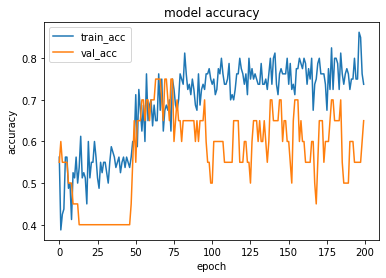

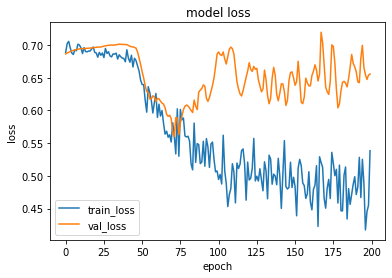

1it [00:00, 14315.03it/s]
file is another_control.mov, prediction is [[0.1888986]]
1it [00:00, 16912.52it/s]
file is short_armflapping.mov, prediction is [[0.37871122]]
1it [00:00, 14513.16it/s]
file is control_far.mov, prediction is [[0.1822916]]
1it [00:00, 13189.64it/s]
file is long_armflapping.mov, prediction is [[0.22572604]]
1it [00:00, 15887.52it/s]
file is me_reading_control.mov, prediction is [[0.1907064]]
1it [00:00, 14716.86it/s]
file is me_armflapping.mov, prediction is [[0.3909366]]
Epoch 1/200
3/3 [==============================] - 1s 226ms/step - loss: 0.6918 - accuracy: 0.5125 - precision_32: 0.5161 - recall_32: 0.4000 - val_loss: 0.6958 - val_accuracy: 0.5000 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00
Epoch 2/200
3/3 [==============================] - 0s 141ms/step - loss: 0.6885 - accuracy: 0.5375 - precision_32: 0.5455 - recall_32: 0.4500 - val_loss: 0.6957 - val_accuracy: 0.5000 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00
Epoch 3/200
3

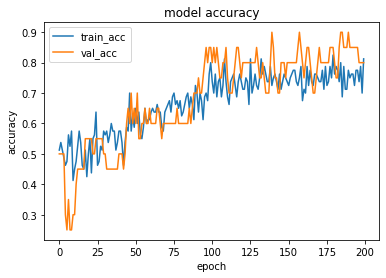

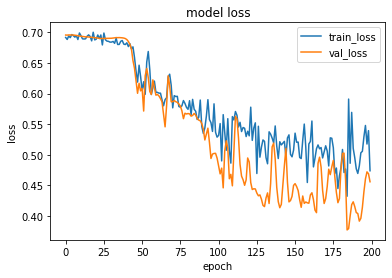

1it [00:00, 13530.01it/s]
file is another_control.mov, prediction is [[0.33143985]]
1it [00:00, 17924.38it/s]
file is short_armflapping.mov, prediction is [[0.5656042]]
1it [00:00, 18236.10it/s]
file is control_far.mov, prediction is [[0.3245036]]
1it [00:00, 14074.85it/s]
file is long_armflapping.mov, prediction is [[0.39762902]]
1it [00:00, 17260.51it/s]
file is me_reading_control.mov, prediction is [[0.32432827]]
1it [00:00, 14315.03it/s]
file is me_armflapping.mov, prediction is [[0.676399]]
Epoch 1/200
3/3 [==============================] - 1s 234ms/step - loss: 0.6997 - accuracy: 0.3500 - precision_33: 0.3243 - recall_33: 0.3077 - val_loss: 0.6910 - val_accuracy: 0.5500 - val_precision_33: 0.5833 - val_recall_33: 0.6364
Epoch 2/200
3/3 [==============================] - 0s 144ms/step - loss: 0.6989 - accuracy: 0.4375 - precision_33: 0.4118 - recall_33: 0.3590 - val_loss: 0.6914 - val_accuracy: 0.5500 - val_precision_33: 0.5833 - val_recall_33: 0.6364
Epoch 3/200
3/3 [============

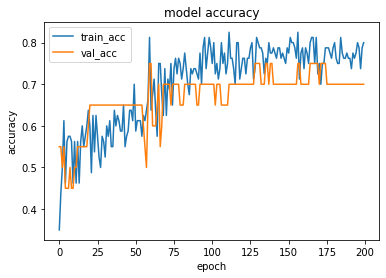

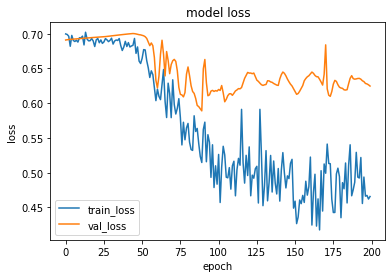

1it [00:00, 15887.52it/s]
file is another_control.mov, prediction is [[0.16714641]]
1it [00:00, 13357.66it/s]
file is short_armflapping.mov, prediction is [[0.6617034]]
1it [00:00, 18808.54it/s]
file is control_far.mov, prediction is [[0.15481874]]
1it [00:00, 19691.57it/s]
file is long_armflapping.mov, prediction is [[0.25699174]]
1it [00:00, 3923.58it/s]
file is me_reading_control.mov, prediction is [[0.17487139]]
1it [00:00, 21183.35it/s]file is me_armflapping.mov, prediction is [[0.66852796]]



In [30]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True)
cross_validate(make_simple_model, epochs = 200, callbacks=[checkpoint])

In [32]:
checkpoint